In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import plotly.express as px
import plotly.graph_objects as go
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import streamlit as st

In [4]:
# Define stock tickers
tickers = ['NVDA', 'AAPL', 'TSLA', 'MSFT', 'GOOGL', 'AMZN']

# Fetch historical data for the last 5 years
data = {}
for ticker in tickers:
    data[ticker] = yf.Ticker(ticker).history(period="5y")

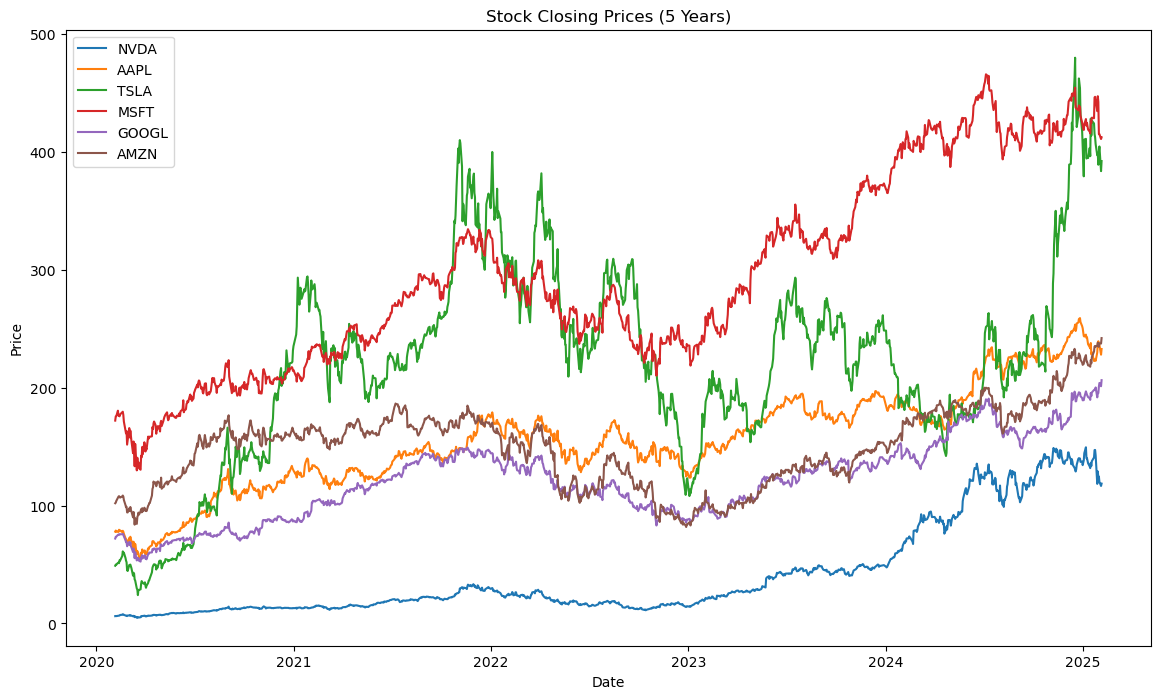


NVDA Summary Statistics:
count    1257.000000
mean       40.711724
std        40.007244
min         4.892426
25%        13.820411
50%        22.063599
75%        46.813751
max       149.429993
Name: Close, dtype: float64

AAPL Summary Statistics:
count    1257.000000
mean      155.181240
std        42.164582
min        54.509758
25%       129.037766
50%       152.668610
75%       179.588409
max       259.019989
Name: Close, dtype: float64

TSLA Summary Statistics:
count    1257.000000
mean      219.984972
std        83.624457
min        24.081333
25%       177.479996
50%       222.643326
75%       262.899994
max       479.859985
Name: Close, dtype: float64

MSFT Summary Statistics:
count    1257.000000
mean      293.924484
std        82.029520
min       129.881088
25%       233.420685
50%       280.691132
75%       349.472046
max       465.786438
Name: Close, dtype: float64

GOOGL Summary Statistics:
count    1257.000000
mean      120.900257
std        33.326913
min        52.516125
2

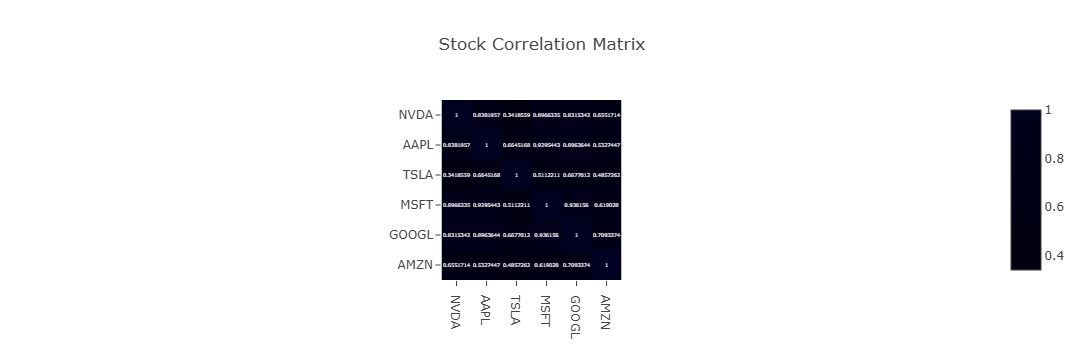

In [6]:
# Plot closing prices for all stocks
plt.figure(figsize=(14, 8))
for ticker in tickers:
    plt.plot(data[ticker].index, data[ticker]['Close'], label=ticker)
plt.title('Stock Closing Prices (5 Years)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

# Statistical summary
for ticker in tickers:
    print(f"\n{ticker} Summary Statistics:")
    print(data[ticker]['Close'].describe())

# Correlation matrix (for stocks)
closing_prices = pd.DataFrame({ticker: data[ticker]['Close'] for ticker in tickers})
corr_matrix = closing_prices.corr()
print("\nCorrelation Matrix:")
print(corr_matrix)

# Visualize correlation matrix
fig = px.imshow(corr_matrix, text_auto=True, title="Stock Correlation Matrix")
fig.show()

In [10]:
# Add technical indicators and lag features
for ticker in tickers:
    df = data[ticker]
    df['Lag1'] = df['Close'].shift(1)
    df['Lag2'] = df['Close'].shift(2)
    df['Lag3'] = df['Close'].shift(3)
    df['SMA_7'] = df['Close'].rolling(window=7).mean()
    df['SMA_30'] = df['Close'].rolling(window=30).mean()
    df['RSI'] = 100 - (100 / (1 + (df['Close'].diff().where(df['Close'].diff() > 0, 0).rolling(window=14).mean() /
                                  -df['Close'].diff().where(df['Close'].diff() < 0, 0).rolling(window=14).mean())))
    data[ticker] = df.dropna()

In [12]:
# Train a Random Forest model for each stock
models = {}
for ticker in tickers:
    df = data[ticker]
    X = df[['Lag1', 'Lag2', 'Lag3', 'SMA_7', 'SMA_30', 'RSI']]
    y = df['Close']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    models[ticker] = model

In [14]:
# Evaluate each model
for ticker in tickers:
    model = models[ticker]
    df = data[ticker]
    X = df[['Lag1', 'Lag2', 'Lag3', 'SMA_7', 'SMA_30', 'RSI']]
    y = df['Close']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    print(f"\n{ticker} Model Evaluation:")
    print(f"RMSE: {rmse}")
    print(f"R²: {r2}")


NVDA Model Evaluation:
RMSE: 2.1156749603147396
R²: 0.9973379362187165

AAPL Model Evaluation:
RMSE: 2.6479671227931747
R²: 0.9954870517370379

TSLA Model Evaluation:
RMSE: 9.118854407337734
R²: 0.9869080425934862

MSFT Model Evaluation:
RMSE: 4.3259014849056285
R²: 0.9970427989703693

GOOGL Model Evaluation:
RMSE: 2.5522554683060825
R²: 0.9936502318408871

AMZN Model Evaluation:
RMSE: 3.1437593317438477
R²: 0.9893008987072398


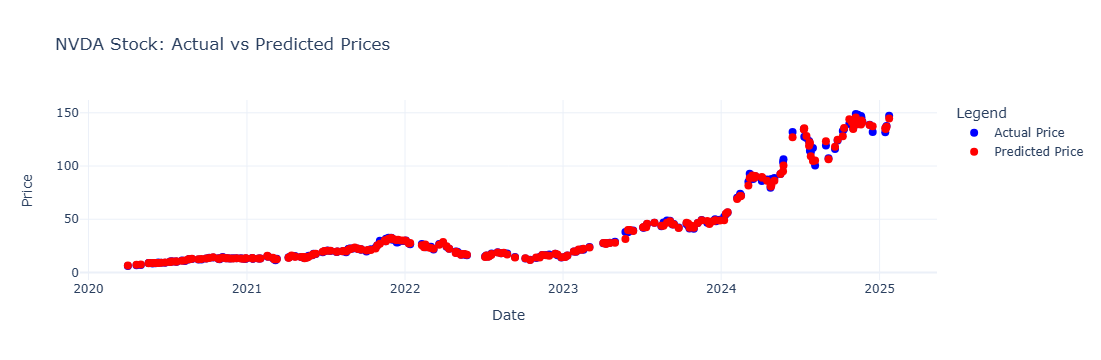

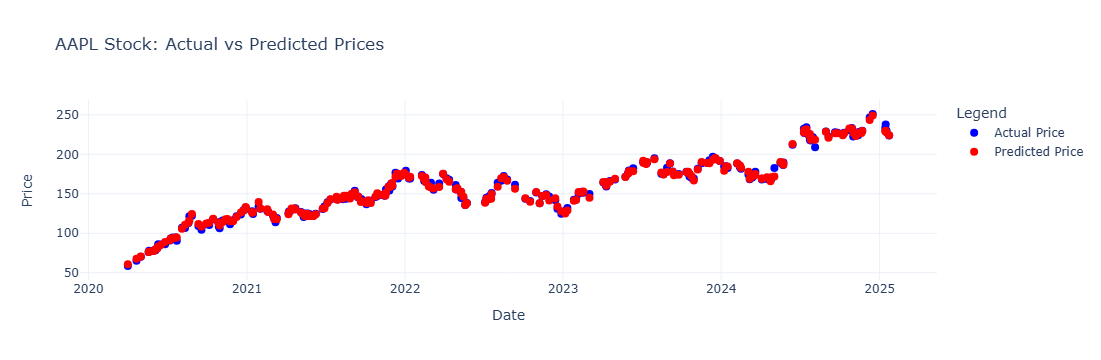

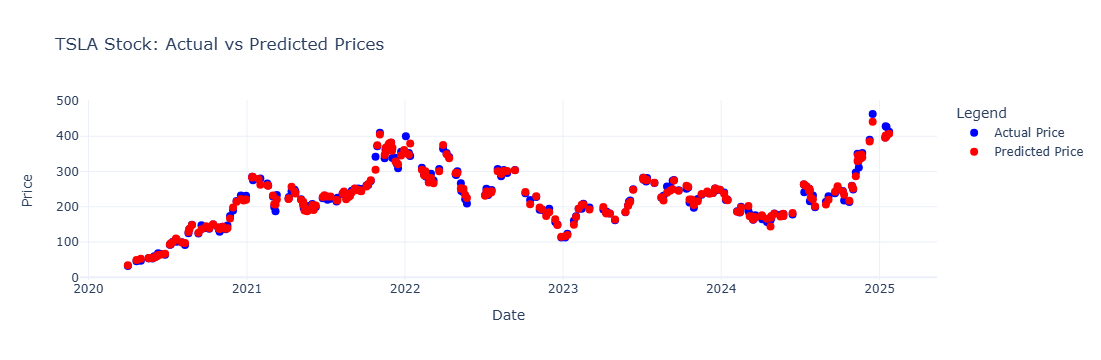

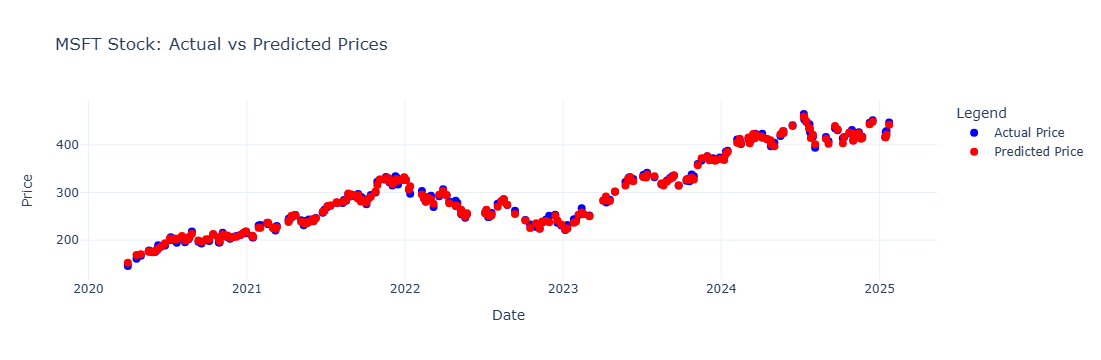

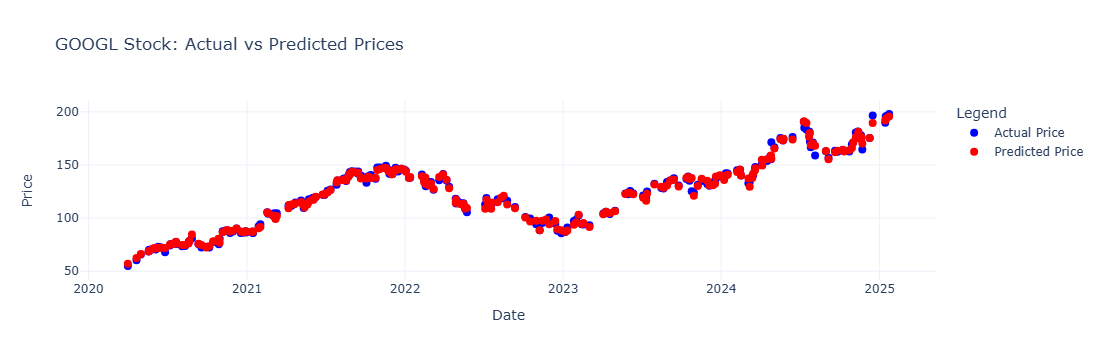

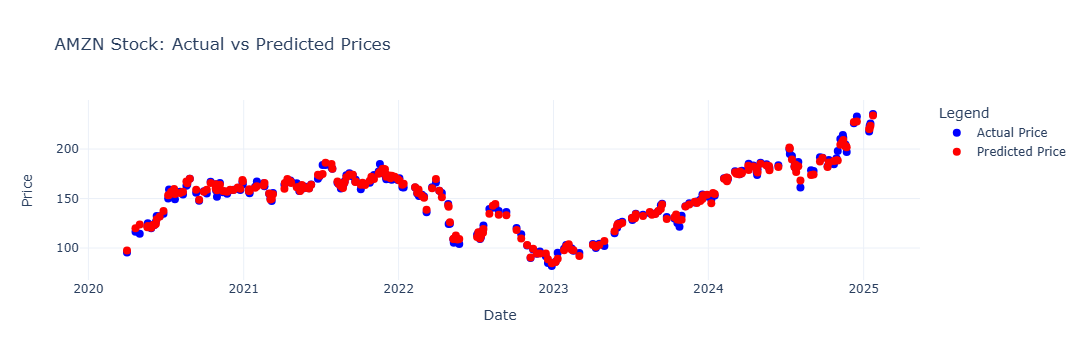

In [40]:
# To visualize the results 
import plotly.graph_objects as go

# Create a scatter plot for actual vs predicted prices
for ticker in tickers:
    model = models[ticker]
    df = data[ticker]
    X = df[['Lag1', 'Lag2', 'Lag3', 'SMA_7', 'SMA_30', 'RSI']]
    y = df['Close']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    y_pred = model.predict(X_test)
    
    # Create a Plotly figure
    fig = go.Figure()
    
    # Add actual prices (blue markers)
    fig.add_trace(go.Scatter(
        x=X_test.index, 
        y=y_test, 
        mode='markers',  # Scatter plot
        name='Actual Price',
        marker=dict(color='blue', size=8)  # Blue markers
    ))
    
    # Add predicted prices (red markers)
    fig.add_trace(go.Scatter(
        x=X_test.index, 
        y=y_pred, 
        mode='markers',  # Scatter plot
        name='Predicted Price',
        marker=dict(color='red', size=8)  # Red markers
    ))
    
    # Update layout
    fig.update_layout(
        title=f"{ticker} Stock: Actual vs Predicted Prices",
        xaxis_title="Date",
        yaxis_title="Price",
        legend_title="Legend",
        template="plotly_white"  # Use a clean template
    )
    
    # Show the figure
    fig.show()

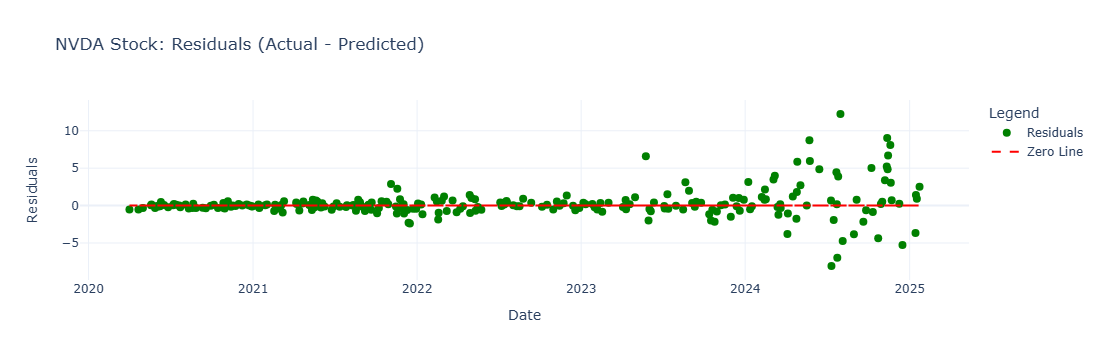

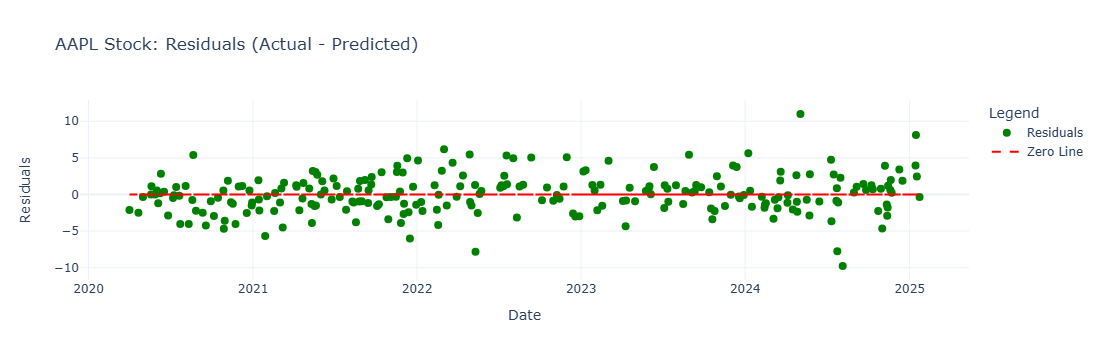

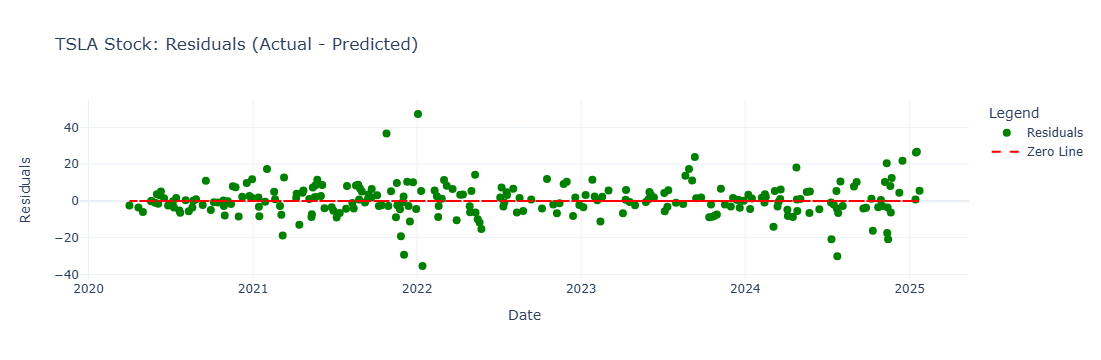

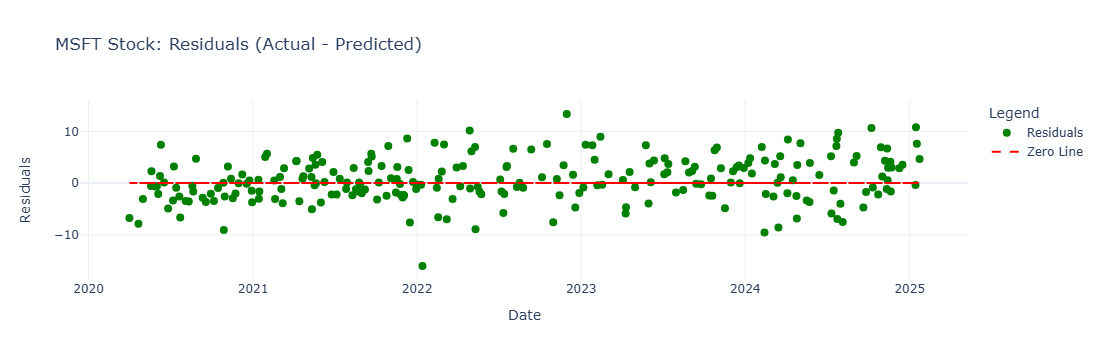

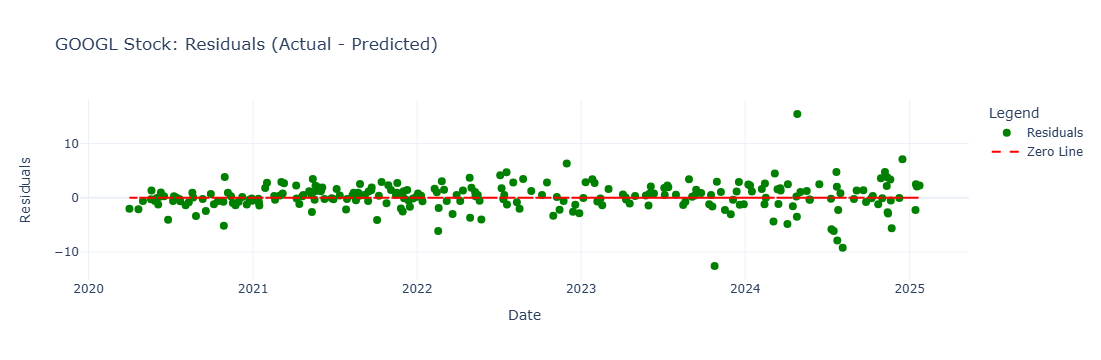

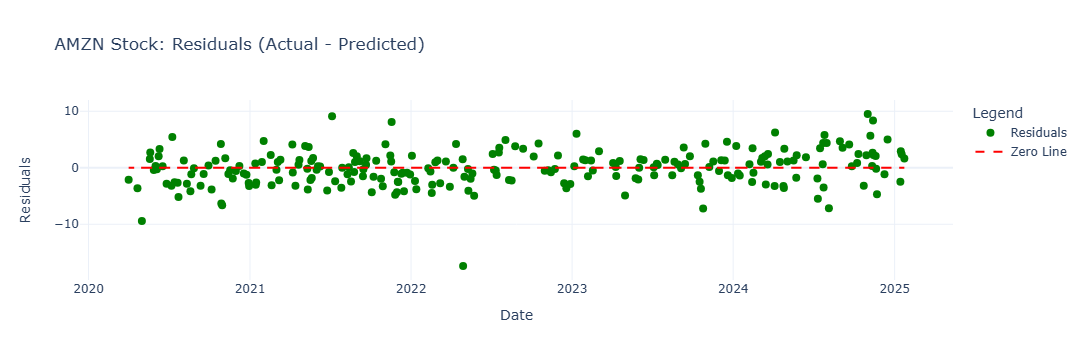

In [46]:
# Creating a residual plot
for ticker in tickers:
    model = models[ticker]
    df = data[ticker]
    X = df[['Lag1', 'Lag2', 'Lag3', 'SMA_7', 'SMA_30', 'RSI']]
    y = df['Close']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    y_pred = model.predict(X_test)
    residuals = y_test - y_pred  # Calculate residuals
    
    # Create a Plotly figure
    fig = go.Figure()
    
    # Add residuals (green markers)
    fig.add_trace(go.Scatter(
        x=X_test.index, 
        y=residuals, 
        mode='markers',  # Scatter plot
        name='Residuals',
        marker=dict(color='green', size=8)  # Green markers
    ))
    
    # Add a horizontal line at zero
    fig.add_trace(go.Scatter(
        x=X_test.index, 
        y=[0] * len(X_test), 
        mode='lines', 
        name='Zero Line',
        line=dict(color='red', width=2, dash='dash')  # Red dashed line
    ))
    
    # Update layout
    fig.update_layout(
        title=f"{ticker} Stock: Residuals (Actual - Predicted)",
        xaxis_title="Date",
        yaxis_title="Residuals",
        legend_title="Legend",
        template="plotly_white"  # Use a clean template
    )
    
    # Show the figure
    fig.show()

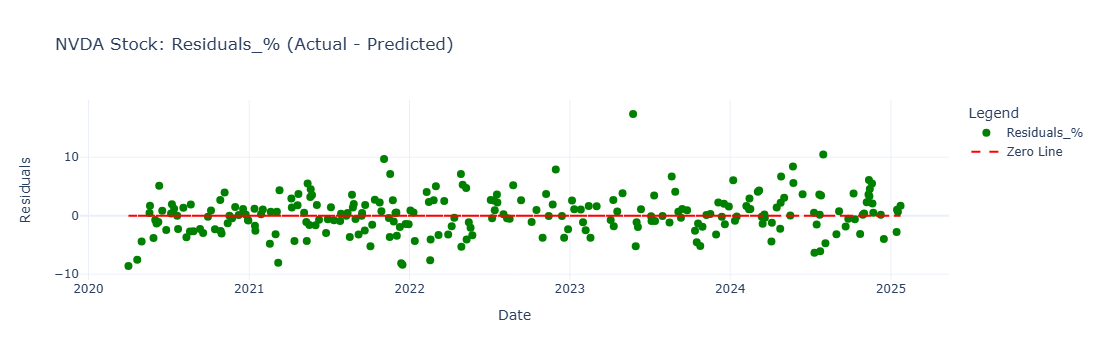

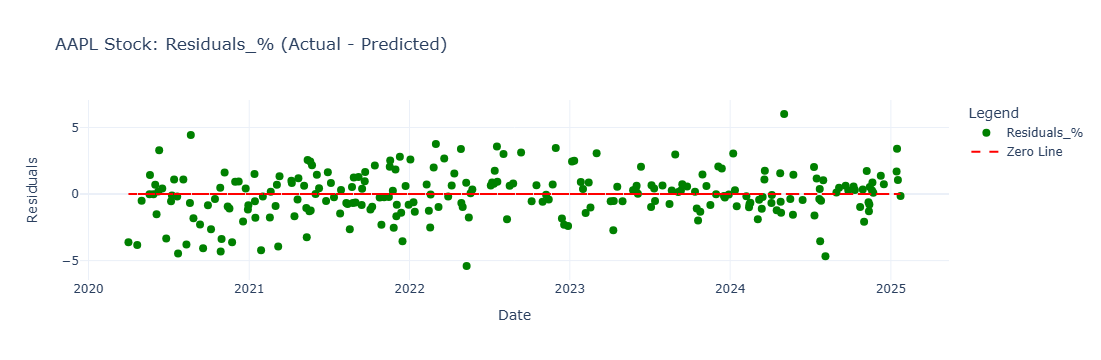

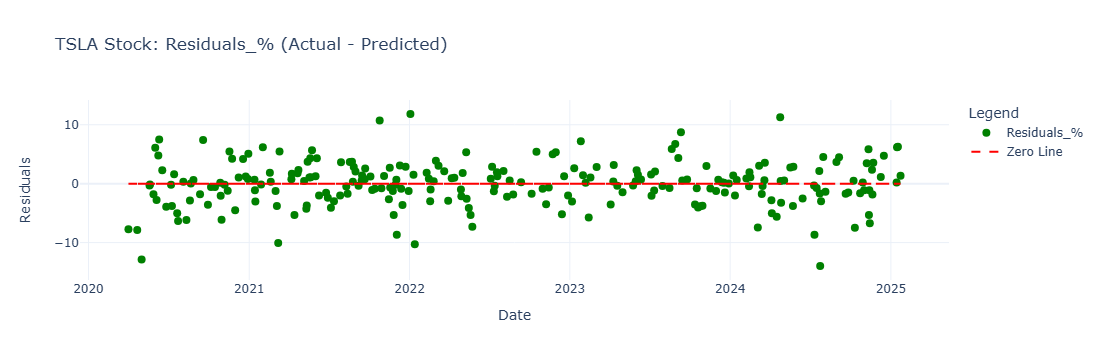

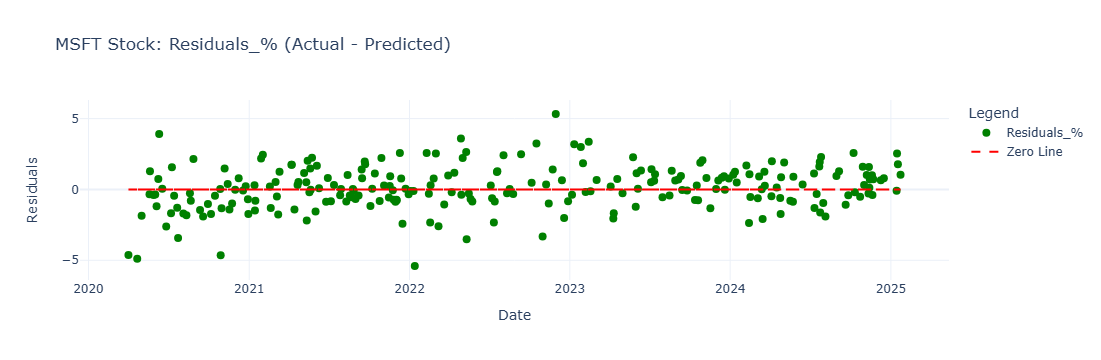

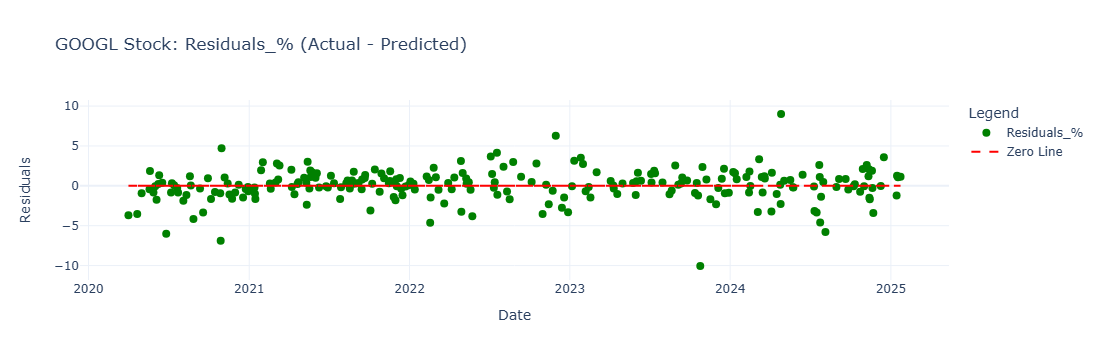

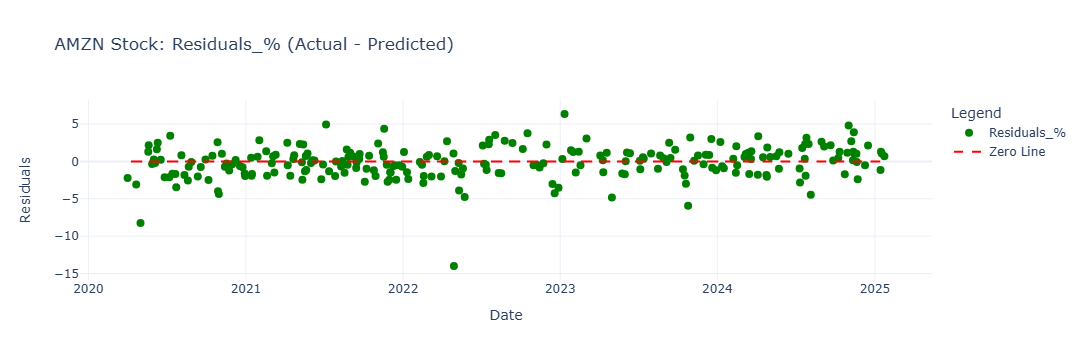

In [62]:
# Creating a residual plot
for ticker in tickers:
    model = models[ticker]
    df = data[ticker]
    X = df[['Lag1', 'Lag2', 'Lag3', 'SMA_7', 'SMA_30', 'RSI']]
    y = df['Close']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    y_pred = model.predict(X_test)
    residuals = y_test - y_pred  # Calculate residuals

    # Calculate percentage residuals
    percentage_residuals = ((y_test - y_pred) / y_test) * 100
    
    # Create a Plotly figure
    fig = go.Figure()
    
    # Add residuals (green markers)
    fig.add_trace(go.Scatter(
        x=X_test.index, 
        y=percentage_residuals, 
        mode='markers',  # Scatter plot
        name='Residuals_%',
        marker=dict(color='green', size=8)  # Green markers
    ))
    
    # Add a horizontal line at zero
    fig.add_trace(go.Scatter(
        x=X_test.index, 
        y=[0] * len(X_test), 
        mode='lines', 
        name='Zero Line',
        line=dict(color='red', width=2, dash='dash')  # Red dashed line
    ))
    
    # Update layout
    fig.update_layout(
        title=f"{ticker} Stock: Residuals_% (Actual - Predicted)",
        xaxis_title="Date",
        yaxis_title="Residuals",
        legend_title="Legend",
        template="plotly_white"  # Use a clean template
    )
    
    # Show the figure
    fig.show()